In [35]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [53]:
# Echemos un vistazo al fichero de CMEs
! cat "Ficheros/CME/univ_all.txt" | head

 ========= SOHO/LASCO CME CATALOG==========      LAST UPDATED: 2020/06/26 18:01
 Date       Time     Central  Width  Linear   2nd order speed      Accel     Mass      Kinetic    MPA   Remarks
                        PA           Speed  initial final   20R                        Energy                 

1996/01/11  00:14:36    267     18    499     571    426      0    -64.3*   -------    -------    272   Only C3
1996/01/13  22:08:30    265     16    290     278    303    372      2.8*   -------    -------    266   Only C3
1996/01/15  07:01:10    262     43    525     600    454      0    -31.1    -------    -------    272   Only C3
1996/01/22  03:11:01    105     37    267     401    130      0   -126.3*   7.1e+13*   2.5e+28*   103   Very Poor Event; Only C3
1996/01/26  09:16:19     90     27    262     254    271    322      1.9*   3.0e+14    1.0e+29     90   Poor Event; Only C3
1996/01/31  06:52:13    274     47    158     219     99      0    -12.3*   2.5e+14*   3.2e+28*   272   Poo

In [130]:
# Con lo que vemos y las descripciones de los campos (ver "univ_all.txt") ya podemos cargar el dataframe
columns = ['Date', 'Time', 'Central_PA', 'Width', 'L_speed', '2_I_speed', '2_F_speed', '2_20R_speed', 'Acceleration',
           'Mass', 'K_energy', 'MPA', 'Remarks']
df = pd.read_fwf('Ficheros/CME/univ_all.txt', skiprows = 4, header = None, names = columns, index_col = False,
                na_values = [0, '', '--', '---', '----', '-----', '------', '-------', '********', 'Halo'])
# Incluimos 'Halo' entre los reconocibles como NaNs porque en la columna "Central_PA" las CMEs con "Width" = 360º vienen
# marcadas así, con la palabra 'Halo'.

In [131]:
# Un poco de información...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30321 entries, 0 to 30320
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          30321 non-null  object 
 1   Time          30321 non-null  object 
 2   Central_PA    29551 non-null  float64
 3   Width         30321 non-null  int64  
 4   L_speed       30213 non-null  float64
 5   2_I_speed     28997 non-null  float64
 6   2_F_speed     29756 non-null  float64
 7   2_20R_speed   23256 non-null  float64
 8   Acceleration  29831 non-null  object 
 9   Mass          19738 non-null  object 
 10  K_energy      19706 non-null  object 
 11  MPA           30299 non-null  float64
 12  Remarks       21109 non-null  object 
dtypes: float64(6), int64(1), object(6)
memory usage: 3.0+ MB


In [132]:
# Empecemos con los NaN
df.isna().sum()

Date                0
Time                0
Central_PA        770
Width               0
L_speed           108
2_I_speed        1324
2_F_speed         565
2_20R_speed      7065
Acceleration      490
Mass            10583
K_energy        10615
MPA                22
Remarks          9212
dtype: int64

In [133]:
# Hay bastantes, interpolaremos las columnas:
df['Central_PA'].fillna(method = 'ffill', inplace = True)
df['L_speed'].fillna(method = 'ffill', inplace = True)
df['2_I_speed'].fillna(method = 'ffill', inplace = True)
df['2_F_speed'].fillna(method = 'ffill', inplace = True)
df['2_20R_speed'].fillna(method = 'ffill', inplace = True)
df['2_20R_speed'].fillna(method = 'bfill', inplace = True)
df['Acceleration'].fillna(method = 'ffill', inplace = True)
df['MPA'].fillna(method = 'ffill', inplace = True)

In [134]:
# Nuestra columna target será "K_energy", que se calcula a partir de la masa ("Mass") y la velocidad lineal ("L_speed")
# por tanto eliminamos dichas columnas, asi como otras que no nos interesan
df.drop(['Mass', 'L_speed'], axis = 'columns', inplace = True)
df.drop(['Time', 'Remarks'], axis = 'columns', inplace = True)

In [135]:
# Los NaNs que quedan son los de "K_energy" no podemos interpolarlos, pues es la variable objetivo. Con todo el dolor 
# del corazón los eliminamos
df.dropna(inplace = True)

In [136]:
# Los campos "Acceleration" y "K_energy" hay que limpiarlos para poder tratarlos
df['Acceleration'] = df['Acceleration'].str.rstrip('*')
df['Acceleration'] = df['Acceleration'].astype(float)
df['K_energy'] = df['K_energy'].str.rstrip('*')
df['K_energy'] = df['K_energy'].astype(float)

In [137]:
# Veamos entonces como queda todo
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19706 entries, 3 to 30123
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          19706 non-null  object 
 1   Central_PA    19706 non-null  float64
 2   Width         19706 non-null  int64  
 3   2_I_speed     19706 non-null  float64
 4   2_F_speed     19706 non-null  float64
 5   2_20R_speed   19706 non-null  float64
 6   Acceleration  19706 non-null  float64
 7   K_energy      19706 non-null  float64
 8   MPA           19706 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.5+ MB


In [138]:
df

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA
3,1996/01/22,105.0,37,401.0,130.0,372.0,-126.3,2.500000e+28,103.0
4,1996/01/26,90.0,27,254.0,271.0,322.0,1.9,1.000000e+29,90.0
5,1996/01/31,274.0,47,219.0,99.0,322.0,-12.3,3.200000e+28,272.0
6,1996/02/03,83.0,52,294.0,317.0,309.0,0.9,8.900000e+29,80.0
7,1996/02/08,263.0,70,247.0,126.0,309.0,-6.0,2.700000e+28,249.0
...,...,...,...,...,...,...,...,...,...
30116,2019/12/26,99.0,58,196.0,104.0,1903.0,-11.1,9.200000e+27,109.0
30119,2019/12/27,302.0,21,62.0,779.0,2036.0,171.2,1.200000e+28,296.0
30121,2019/12/27,284.0,46,488.0,405.0,136.0,-9.1,5.900000e+28,289.0
30122,2019/12/30,277.0,39,29.0,75.0,195.0,1.6,6.900000e+27,278.0


In [139]:
# Pasamos la fecha al formato que nos interesa
df['Date'] = pd.to_datetime(df['Date'])

In [140]:
df

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA
3,1996-01-22,105.0,37,401.0,130.0,372.0,-126.3,2.500000e+28,103.0
4,1996-01-26,90.0,27,254.0,271.0,322.0,1.9,1.000000e+29,90.0
5,1996-01-31,274.0,47,219.0,99.0,322.0,-12.3,3.200000e+28,272.0
6,1996-02-03,83.0,52,294.0,317.0,309.0,0.9,8.900000e+29,80.0
7,1996-02-08,263.0,70,247.0,126.0,309.0,-6.0,2.700000e+28,249.0
...,...,...,...,...,...,...,...,...,...
30116,2019-12-26,99.0,58,196.0,104.0,1903.0,-11.1,9.200000e+27,109.0
30119,2019-12-27,302.0,21,62.0,779.0,2036.0,171.2,1.200000e+28,296.0
30121,2019-12-27,284.0,46,488.0,405.0,136.0,-9.1,5.900000e+28,289.0
30122,2019-12-30,277.0,39,29.0,75.0,195.0,1.6,6.900000e+27,278.0


In [141]:
# Agrupamos por fecha, el valor que nos interesa de cada campo es la media:
df_g = df.groupby('Date').mean().reset_index()

In [142]:
# Comprobamos la estadística de nuestro dataframe
df_g.describe()

,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA
count,6553.000000,6553.000000,6553.000000,6553.000000,6553.000000,6553.000000,6.553000e+03,6553.000000
mean,179.992605,69.490918,359.203055,393.939621,545.972617,2.270486,5.627735e+30,180.308322
std,72.431963,47.728418,232.638541,203.565898,288.704705,20.753967,6.421144e+31,72.388486
min,1.000000,11.000000,2.000000,9.000000,21.000000,-232.000000,5.500000e+24,1.000000
25%,120.200000,40.000000,210.000000,265.500000,368.000000,-3.840000,6.700000e+28,120.600000
50%,180.800000,57.000000,312.666667,361.666667,496.600000,1.833333,3.855000e+29,181.250000
75%,239.500000,82.000000,454.000000,478.600000,653.000000,7.200000,1.968700e+30,239.333333
max,359.000000,360.000000,3703.000000,2558.000000,3728.000000,446.100000,4.200000e+33,359.000000


In [143]:
# Vamos con los outliers, para decidir cuales quitar usaremos gráficas de distribución así como los valores de 
# media y desviación estándar

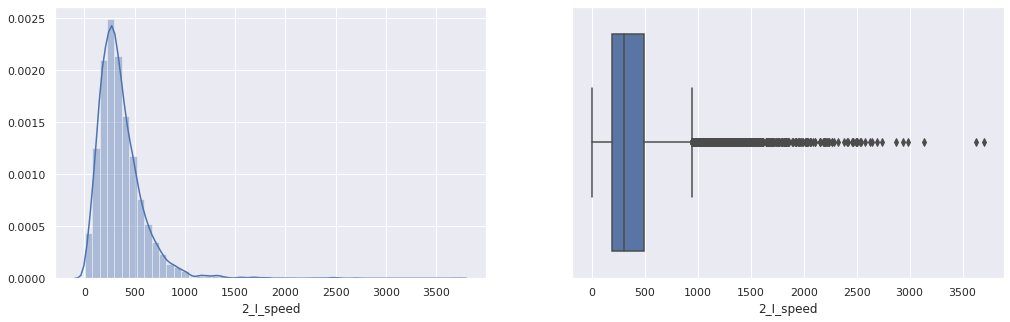

In [144]:
# 2_I_speed
sns.set(rc = {'figure.figsize':(17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_I_speed'], ax = ax[0])
sns.boxplot(df['2_I_speed'], ax = ax[1])
fig.show()

In [145]:
#Teniendo en cuenta lo que hemos dicho
df_g.drop(df_g[df_g['2_I_speed'] >= 1500].index, inplace =True)

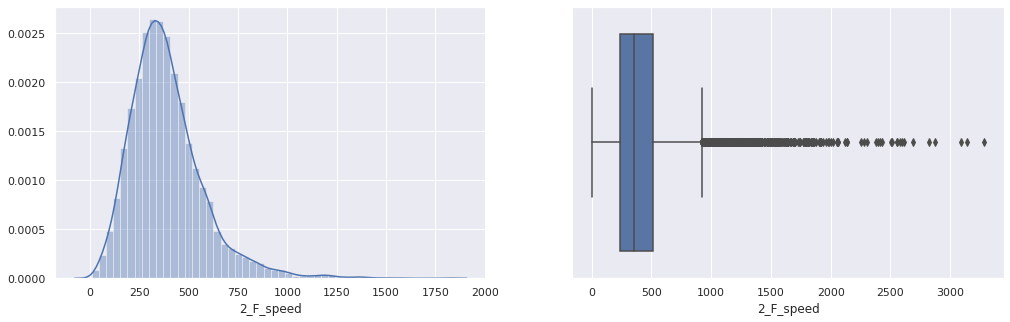

In [146]:
# 2_F_speed
sns.set(rc = {'figure.figsize':(17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_F_speed'], ax = ax[0])
sns.boxplot(df['2_F_speed'], ax = ax[1])
fig.show()

In [147]:
df_g.drop(df_g[df_g['2_F_speed'] >= 1500].index, inplace =True)

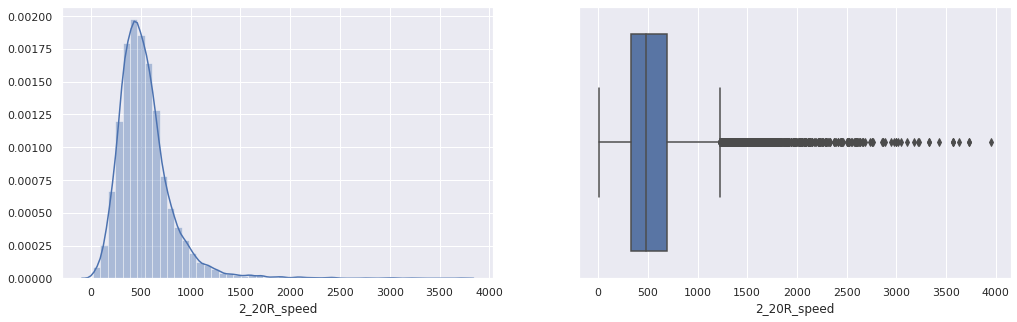

In [148]:
# 2_20R_speed
sns.set(rc = {'figure.figsize':(17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_20R_speed'], ax = ax[0])
sns.boxplot(df['2_20R_speed'], ax = ax[1])
fig.show()

In [149]:
df_g.drop(df_g[df_g['2_20R_speed'] >= 2000].index, inplace =True)

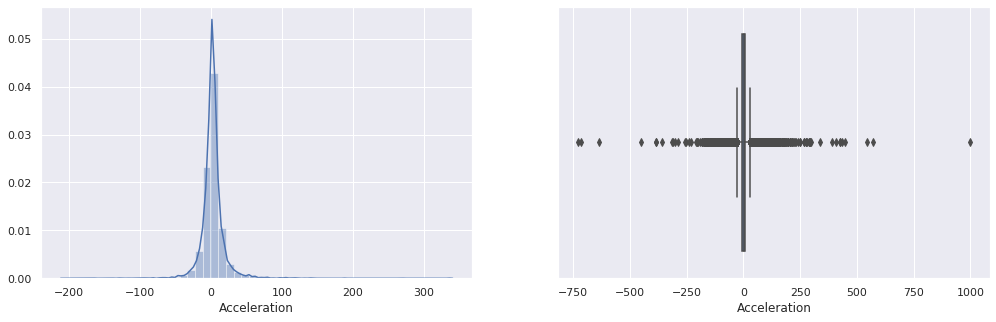

In [150]:
# Acceleration
sns.set(rc = {'figure.figsize':(17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Acceleration'], ax = ax[0])
sns.boxplot(df['Acceleration'], ax = ax[1])
fig.show()

In [151]:
# La columna "Acceleration" es difícil por su distribución y porque se nos dice que son valores poco fiables...
# Vamos a ser más estrictos a la hora de limitar por arriba y por abajo
df_g.drop(df_g[df_g['Acceleration'] > 200].index, inplace =True)
df_g.drop(df_g[df_g['Acceleration'] < -200].index, inplace =True)

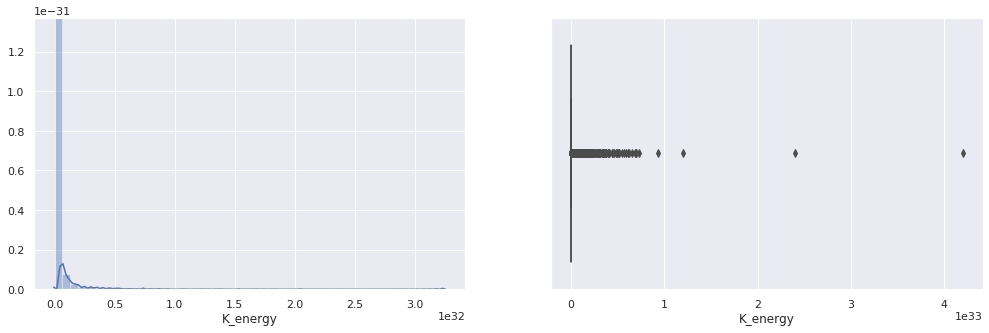

In [152]:
# K_energy
sns.set(rc = {'figure.figsize':(17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['K_energy'], ax = ax[0])
sns.boxplot(df['K_energy'], ax = ax[1])
fig.show()

In [153]:
# Vamos a ver la distribución más en detalle, tomando intervalos lógicos entre el mínimo y el máximo
cond1 = (df_g['K_energy'] > 1e+24) & (df_g['K_energy'] < 1e+25) 
cond2 = (df_g['K_energy'] >= 1e+25) & (df_g['K_energy'] < 1e+26) 
cond3 = (df_g['K_energy'] >= 1e+26) & (df_g['K_energy'] < 1e+27)
cond4 = (df_g['K_energy'] >= 1e+27) & (df_g['K_energy'] < 1e+28) 
cond5 = (df_g['K_energy'] >= 1e+28) & (df_g['K_energy'] < 1e+29) 
cond6 = (df_g['K_energy'] >= 1e+29) & (df_g['K_energy'] < 1e+30)
cond7 = (df_g['K_energy'] >= 1e+30) & (df_g['K_energy'] < 1e+31) 
cond8 = (df_g['K_energy'] >= 1e+31) & (df_g['K_energy'] < 1e+32) 
cond9 = (df_g['K_energy'] >= 1e+32) 

print(len(df_g[cond1]), len(df_g[cond2]), len(df_g[cond3]), len(df_g[cond4]), len(df_g[cond5]), len(df_g[cond6]), 
len(df_g[cond7]), len(df_g[cond8]), len(df_g[cond9]))

1 9 78 460 1416 2229 1818 457 26


In [154]:
# Eliminaremos los correspondientes a los tramos 1, 2 y 9
df_g.drop(df_g[cond1].index, inplace =True)
df_g.drop(df_g[cond2].index, inplace =True)
df_g.drop(df_g[cond9].index, inplace =True)

In [155]:
# En realidad lo que nos interesa no es el valor exacto de K_energy, sino el "rango". Para facilitar las cosas vamos a 
# discretizar la variable en una serie de tramos

In [156]:
# Definimos una función para clasificar los valores, asignaremos números del 1 al 6 según la intensidad de K_energy
def Classifier(value):
    result = 0
    if (value > 1e+26) and (value < 1e+27):
        result = 1
    elif (value >= 1e+27) and (value < 1e+28):
        result = 2
    elif (value >= 1e+28) and (value < 1e+29):
        result = 3
    elif (value >= 1e+29) and (value < 1e+30):
        result = 4
    elif (value >= 1e+30) and (value < 1e+31):
        result = 5
    elif (value >= 1e+31):
        result = 6
    
    return result    

In [157]:
# Creamos una nueva columna con la clasificación
df_g['Class2'] = df_g['K_energy'].apply(Classifier)

In [92]:
df_g

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA,Class
1,1996-01-26,90.0,27.0,254.0,271.0,322.0,1.90,1.000000e+29,90.0,4
2,1996-01-31,274.0,47.0,219.0,99.0,322.0,-12.30,3.200000e+28,272.0,3
3,1996-02-03,83.0,52.0,294.0,317.0,309.0,0.90,8.900000e+29,80.0,4
4,1996-02-08,263.0,70.0,247.0,126.0,309.0,-6.00,2.700000e+28,249.0,3
5,1996-02-12,91.0,53.0,100.0,211.0,236.0,2.00,1.600000e+29,92.0,4
...,...,...,...,...,...,...,...,...,...,...
6548,2019-12-24,282.0,57.0,157.0,288.0,615.0,14.60,1.500000e+28,289.0,3
6549,2019-12-25,274.0,49.0,337.0,245.0,1903.0,-14.30,1.300000e+28,268.0,3
6550,2019-12-26,99.0,58.0,196.0,104.0,1903.0,-11.10,9.200000e+27,109.0,2
6551,2019-12-27,293.0,33.5,275.0,592.0,1086.0,81.05,3.550000e+28,292.5,3


In [159]:
# Ya no necesitamos K_energy
df_g.drop(['K_energy'], axis = 'columns', inplace = True)

In [160]:
df_g

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,MPA,Class2
0,1996-01-22,105.0,37.0,401.0,130.0,372.0,-126.30,103.0,3
1,1996-01-26,90.0,27.0,254.0,271.0,322.0,1.90,90.0,4
2,1996-01-31,274.0,47.0,219.0,99.0,322.0,-12.30,272.0,3
3,1996-02-03,83.0,52.0,294.0,317.0,309.0,0.90,80.0,4
4,1996-02-08,263.0,70.0,247.0,126.0,309.0,-6.00,249.0,3
...,...,...,...,...,...,...,...,...,...
6548,2019-12-24,282.0,57.0,157.0,288.0,615.0,14.60,289.0,3
6549,2019-12-25,274.0,49.0,337.0,245.0,1903.0,-14.30,268.0,3
6550,2019-12-26,99.0,58.0,196.0,104.0,1903.0,-11.10,109.0,2
6551,2019-12-27,293.0,33.5,275.0,592.0,1086.0,81.05,292.5,3


In [161]:
# Guardamos
df.to_csv('CME_new.csv', index = False)